<a href="https://colab.research.google.com/github/alicepearse/DL_prac/blob/master/CNN_CIFAR10_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [24]:
transformer_train = torchvision.transforms.Compose([
  # torchvision.transforms.ColorJitter(
  #     brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  transforms.RandomCrop(32, padding=4),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  # torchvision.transforms.RandomRotation(degrees=15),
  torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
  # torchvision.transforms.RandomPerspective(),
  transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transformer_train,
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [26]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [27]:
# number of classes
K = len(set(train_dataset.targets))
print("number of classes:", K)

number of classes: 10


In [28]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [29]:
train_dataset_fixed = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
train_loader_fixed = torch.utils.data.DataLoader(
    dataset=train_dataset_fixed, 
    batch_size=batch_size, 
    shuffle=False)

Files already downloaded and verified


In [30]:
# Build the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    
    # define the conv layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )

    # H_out = H_in + 2p - 2 --> p = 1 if H_out = H_in

    # define the linear layers
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, K)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x


In [31]:
model = CNN(K)

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [33]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [34]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) 
    
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [35]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=80)

Epoch 1/80, Train Loss: 1.4549,       Test Loss: 1.0519, Duration: 0:05:23.151036
Epoch 2/80, Train Loss: 1.0092,       Test Loss: 0.8882, Duration: 0:05:26.217646
Epoch 3/80, Train Loss: 0.8547,       Test Loss: 0.7868, Duration: 0:05:26.395541
Epoch 4/80, Train Loss: 0.7607,       Test Loss: 0.7279, Duration: 0:05:25.761998
Epoch 5/80, Train Loss: 0.6848,       Test Loss: 0.6896, Duration: 0:05:26.701913
Epoch 6/80, Train Loss: 0.6448,       Test Loss: 0.6606, Duration: 0:05:26.553035
Epoch 7/80, Train Loss: 0.6132,       Test Loss: 0.6205, Duration: 0:05:28.987148
Epoch 8/80, Train Loss: 0.5833,       Test Loss: 0.6217, Duration: 0:05:30.626907
Epoch 9/80, Train Loss: 0.5532,       Test Loss: 0.5876, Duration: 0:05:29.036997
Epoch 10/80, Train Loss: 0.5357,       Test Loss: 0.5694, Duration: 0:05:29.248048
Epoch 11/80, Train Loss: 0.5126,       Test Loss: 0.5751, Duration: 0:05:28.388441
Epoch 12/80, Train Loss: 0.5015,       Test Loss: 0.5541, Duration: 0:05:30.686961
Epoch 13/80, 

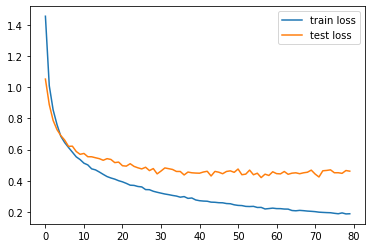

In [36]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [37]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader_fixed:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  
  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9291, Test acc: 0.8647


In [38]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[858  18  35   9  10   0   7   4  30  29]
 [  6 922   0   3   1   0   2   0   4  62]
 [ 26   1 796  41  52  20  42   9   5   8]
 [ 17   6  26 716  54  99  41  21   4  16]
 [  7   0  26  16 893   8  18  26   1   5]
 [  6   3  26 118  30 772  11  30   0   4]
 [  7   1  14  21  28   5 911   3   3   7]
 [ 13   3  15  17  34  11   6 890   2   9]
 [ 39   9   4   3   2   1   1   0 916  25]
 [  9  24   2   3   0   0   2   1   8 951]]


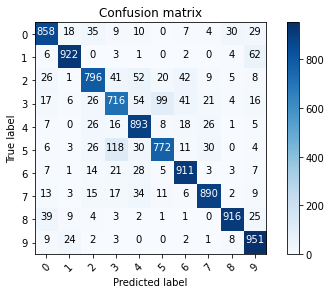

In [39]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [40]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

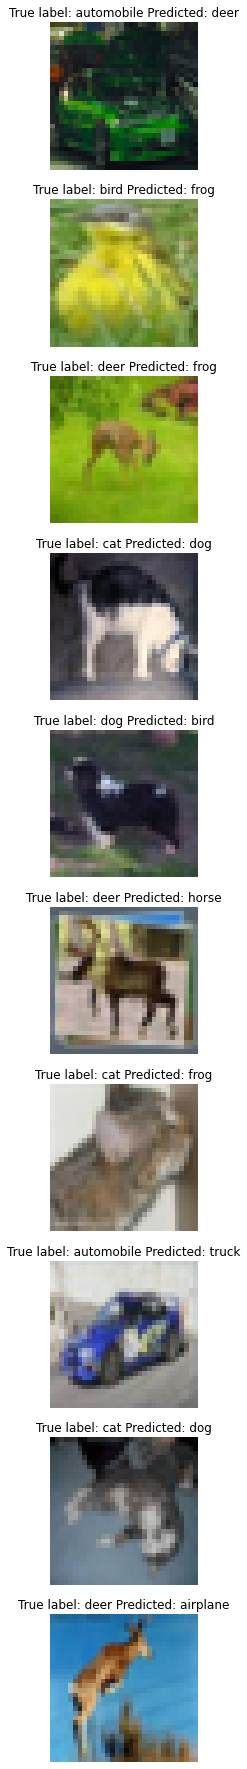

In [41]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx, 10, replace=False)
plt.figure(figsize=(32,32))
for j, i in enumerate(sample_idx):
  plt.subplot(10, 1, j + 1)
  plt.axis('off')
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

In [42]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6